* Froude number plots at peak ebbs and floods.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import matplotlib.pyplot as plt
import StraTimeSeries as sts
import R_mixStuff as RS
import FroudeNumber as FN
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2., rc={"lines.linewidth": 2.5})
%matplotlib inline

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 
e3t = mesh.variables['e3t'][0,:,380:510,240:397]

In [3]:
## Jan results
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc','r')
janall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc','r')
janall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_V.nc','r')

## Oct results
octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc','r')
octall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc','r')
octall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc','r')

## May results
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc','r')
mayall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc','r')
mayall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_V.nc','r')

In [4]:
def determine_plume_method2_onlysalinity(grid_T,tst,ted,dep_ind,ave_flag = False):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain and not plot them, only get the
    threshold salinity"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S_aveN = np.nanmean(S[tst:ted,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    if ave_flag == False:
        S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average at specific depth
        S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0)
    elif ave_flag == True:
        S_ref = np.nanmean(S_aveN[0:dep_ind+1]) ## then spatial average, including depth
        S_aveW = np.nanmean(np.nanmean(S[tst:ted],axis = 0),axis = 0)
    S_thre = 1.14*S_ref-4.8
    #S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0) ## temporal averaged of the whole domain
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    return S_thre, S_aveW

In [5]:
def plot_spatial(grid_T,grid_U,grid_V,t,tst,ted,dep_ind,ti,levels,lonmax,lonmin,latmax,latmin,flag):
    """Spatial plot of Fr number if flag = 'Fr', baroclinic velocity if flag = 'baroclinic',
    internal wave speed if flag = 'internal'"""
    Fr,to_speed_inte,rho_inte,g_prime= FN.Fr_No(grid_T,grid_U,grid_V,t,dep_ind,ti)
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    fig,ax = plt.subplots(1,1,figsize = (8,5))
    ## below are time averaged variable
    if flag =='Fr': ## 
        snapshot = Fr[ti]
        string = 'Froude Number'
    elif flag =='momentum':
        snapshot = to_speed_inte[ti]/rho_inte[ti]
        string = 'momentum [m/s]'
    elif flag == 'internal':
        snapshot = np.sqrt(g_prime[ti]*dep[dep_ind])
        string = 'Internal wave speed [m/s]'
    CS = ax.contourf(lon[1:,1:],lat[1:,1:],snapshot,levels,cmap = 'plasma_r',extend='both')
    CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))
    cbar = fig.colorbar(CS,ax = ax)
    cbar.add_lines(CS2)
    cbar.set_label(string)
    
    S_thre,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,0) ## use surface salinity to define plume edge
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre-2,S_thre,S_thre+2], colors='c',linewidths=(2,))
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([lonmin,lonmax])
    ax.set_ylim([latmin,latmax])
    return snapshot

In [6]:
def plot_together(grid_T,grid_U,grid_V,t,tst,ted,dep_ind,ti,S_thre,levels_Fr,levels_M,levels_B,lonmax,lonmin,latmax,latmin):
    """Plot ssh at PA, Froude number, momentum and buoyancy together for 
    three different flow periods"""
    Fr,to_speed_inte,rho_inte,g_prime= FN.Fr_No(grid_T,grid_U,grid_V,t,dep_ind,ti)
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    fig, axs = plt.subplots(1,3,figsize = (20,5))
    for ax, snapshot, string,level,cb in zip(axs,[Fr[ti],to_speed_inte[ti]/rho_inte[ti],np.sqrt(g_prime[ti]*dep[dep_ind])],\
                                    ['Froude Number','Momentum $\mathrm{(m s^{-1})}$','Buoyancy $\mathrm{(m s^{-1})}$'],[levels_Fr,levels_M,levels_B],\
                                    ['plasma_r','Reds','GnBu']):
        CS = ax.contourf(lon[1:,1:],lat[1:,1:],snapshot,level,cmap = cb,extend='both')
        #CS2 = ax.contour(CS, colors = 'k',hold='on',edgecolor =None) if want to remove black border, comment this on
        cbar = fig.colorbar(CS,ax = ax)
        #cbar.add_lines(CS2)
        cbar.set_label(string)
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([lonmin,lonmax])
        ax.set_ylim([latmin,latmax])
        ax.set_xticks([-124,-123.6,-123.2,-122.8])
        ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
    ax = axs[0]
    SS,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,0) ## use surface salinity to define plume edge
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='c',linewidths=(3,))
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)

In [7]:
U = {};SSH = {};
for mon, gridU, gridT in zip(['jan','oct','may'],[janall_U,octall_U,mayall_U],\
                            [janall_T,octall_T,mayall_T]):
    U[mon] = gridU.variables['vozocrtx']
    SSH[mon] = gridT.variables['sossheig']

In [8]:
PET = {}## short form of peak ebb times!
PFT = {}## short form of peak flood times!
month = 'may'
for month in ['jan','oct','may']:
    PET[month] = [];
    PFT[month] = [];
for month in ['jan','oct','may']:
    for t in np.arange(0,len(U[month]),24):
        pet = np.nanargmin(U[month][t:t+24,0,38,72])+t
        PET[month].append(pet)
        pft = np.nanargmax(U[month][t:t+24,0,38,72])+t
        PFT[month].append(pft)

In [9]:
## colormap levels
levels_Fr = [0,0.2,0.4,0.6,0.8,1,1.2,1.4]
levels_M = [0,0.2,0.4,0.6,0.8,1]
levels_B = [0,0.5,1,1.5,2]

lonmin = -124.
lonmax = -122.8
latmin = 48.9
latmax = 49.5 

dep_ind = 10
ti = 'all'

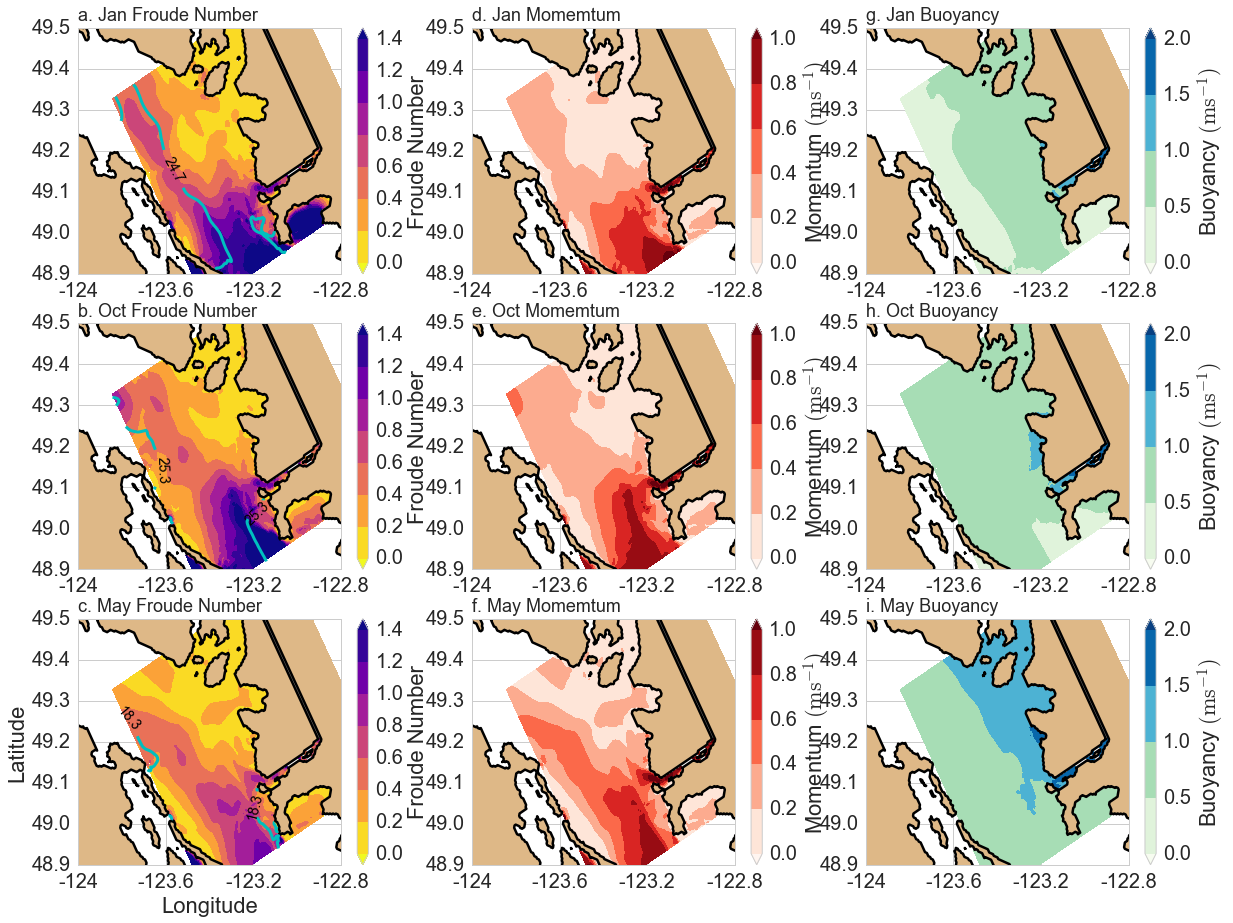

In [12]:
## peak ebbs
fig, axs = plt.subplots(3,3,figsize = (20,15))
for gridT,gridU,gridV, i, t,S_thre in zip([janall_T,octall_T,mayall_T],[janall_U,octall_U,mayall_U],\
                            [janall_V,octall_V,mayall_V], np.arange(3),[194,196,734], [24.7,25.3,18.3]):
    Fr,to_speed_inte,rho_inte,g_prime= FN.Fr_No(gridT,gridU,gridV,t,dep_ind,ti)
    dep = gridT.variables['deptht']
    lon = gridT.variables['nav_lon']
    lat = gridT.variables['nav_lat']
    if i ==0:
        letters = ['a. Jan Froude Number', 'd. Jan Momemtum ', 'g. Jan Buoyancy']
    elif i ==1:
        letters = ['b. Oct Froude Number', 'e. Oct Momemtum', 'h. Oct Buoyancy']
    elif i ==2:
        letters = ['c. May Froude Number', 'f. May Momemtum', 'i. May Buoyancy']
    for ax, snapshot, string,level,cb,letter in zip(axs[i,:],[Fr[ti],to_speed_inte[ti]/rho_inte[ti],np.sqrt(g_prime[ti]*dep[dep_ind])],\
                                    ['Froude Number','Momentum $\mathrm{(m s^{-1})}$','Buoyancy $\mathrm{(m s^{-1})}$'],[levels_Fr,levels_M,levels_B],\
                                    ['plasma_r','Reds','GnBu'], letters):
        CS = ax.contourf(lon[1:,1:],lat[1:,1:],snapshot,level,cmap = cb,extend='both')
        ax.text(0,1.03,letter, transform = ax.transAxes,fontsize = 18)
        cbar = fig.colorbar(CS,ax = ax)
        cbar.set_label(string)
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([lonmin,lonmax])
        ax.set_ylim([latmin,latmax])
        ax.set_xticks([-124,-123.6,-123.2,-122.8])
        ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
        if letter == 'c. May Froude Number':
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
    ax = axs[i,0]
    SS,W = determine_plume_method2_onlysalinity(gridT,t,t+1,0) ## use surface salinity to define plume edge
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='c',linewidths=(3,))
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)

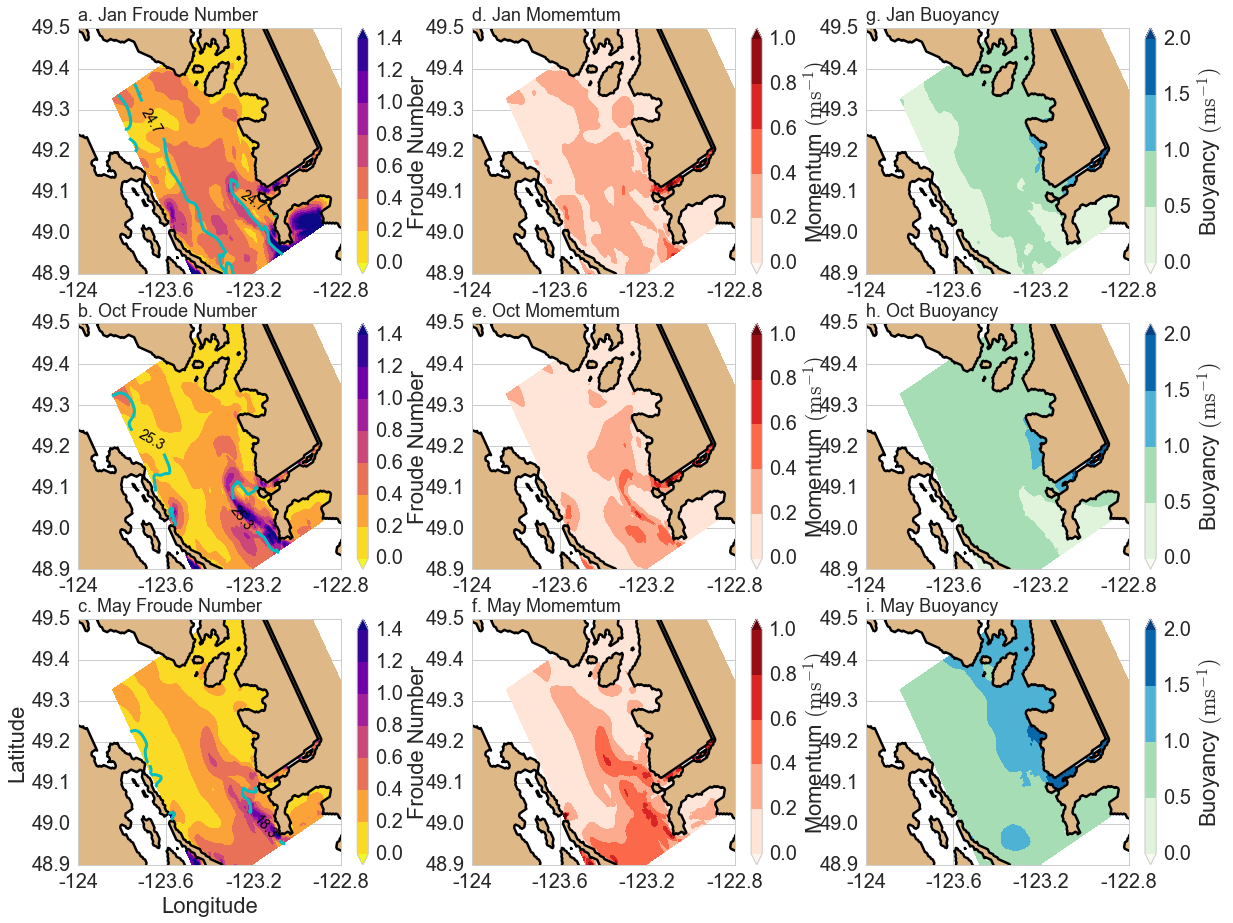

In [13]:
## peak floods
fig, axs = plt.subplots(3,3,figsize = (20,15))
for gridT,gridU,gridV, i, t,S_thre in zip([janall_T,octall_T,mayall_T],[janall_U,octall_U,mayall_U],\
                            [janall_V,octall_V,mayall_V], np.arange(3),[204,204,740],[24.7,25.3,18.3]):
    Fr,to_speed_inte,rho_inte,g_prime= FN.Fr_No(gridT,gridU,gridV,t,dep_ind,ti)
    dep = gridT.variables['deptht']
    lon = gridT.variables['nav_lon']
    lat = gridT.variables['nav_lat']
    if i ==0:
        letters = ['a. Jan Froude Number', 'd. Jan Momemtum ', 'g. Jan Buoyancy']
    elif i ==1:
        letters = ['b. Oct Froude Number', 'e. Oct Momemtum', 'h. Oct Buoyancy']
    elif i ==2:
        letters = ['c. May Froude Number', 'f. May Momemtum', 'i. May Buoyancy']
    for ax, snapshot, string,level,cb,letter in zip(axs[i,:],[Fr[ti],to_speed_inte[ti]/rho_inte[ti],np.sqrt(g_prime[ti]*dep[dep_ind])],\
                                    ['Froude Number','Momentum $\mathrm{(m s^{-1})}$','Buoyancy $\mathrm{(m s^{-1})}$'],[levels_Fr,levels_M,levels_B],\
                                    ['plasma_r','Reds','GnBu'], letters):
        CS = ax.contourf(lon[1:,1:],lat[1:,1:],snapshot,level,cmap = cb,extend='both')
        ax.text(0,1.03,letter, transform = ax.transAxes,fontsize = 18)
        cbar = fig.colorbar(CS,ax = ax)
        cbar.set_label(string)
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([lonmin,lonmax])
        ax.set_ylim([latmin,latmax])
        ax.set_xticks([-124,-123.6,-123.2,-122.8])
        ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
        if letter == 'c. May Froude Number':
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
    ax = axs[i,0]
    SS,W = determine_plume_method2_onlysalinity(gridT,t,t+1,0) ## use surface salinity to define plume edge
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='c',linewidths=(3,))
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
